# Calculating Merger Rate

Calculating and plotting the properties of PBH binaries (PDF etc.). These are then used (along with the remapping procedure) to calculate the average merger rate of PBH binaries today.

In [1]:
%matplotlib inline

import sys
sys.executable
print(sys.executable)
print(sys.version)
print(sys.version_info)

from __future__ import division

import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
from scipy.integrate import odeint
from scipy.special import erf
from scipy.integrate import quad, dblquad
from scipy.interpolate import interp1d,interp2d,RectBivariateSpline, griddata

import emcee

#----- MATPLOTLIB paramaters ---------
mpl.rcParams.update({'font.size': 18,'font.family':'sans-serif'})

mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
#--------------------------------------

/Library/Frameworks/Python.framework/Versions/3.5/bin/python3
3.5.0 (v3.5.0:374f501f4567, Sep 12 2015, 11:00:19) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
sys.version_info(major=3, minor=5, micro=0, releaselevel='final', serial=0)


## Define some constants + parameters

In [2]:
G_N = 4.302e-3 #(pc/solar mass) (km/s)^2
G_N_Mpc = 1e-6*4.302e-3 #(Mpc/solar mass) (km/s)^2

h = 0.678
Omega_DM = 0.1186/(h**2)
H0 = 100.0*h #(km/s) Mpc^-1
H0_peryr = 67.8*(3.24e-20)*(60*60*24*365)
ageUniverse = 13.799e9 #y
Omega_L = 0.692
Omega_m = 0.308
Omega_r = 9.3e-5

z_eq = 3375.0
rho_eq = 1512.0 #Solar masses per pc^3
sigma_eq = 0.005 #Variance of DM density perturbations at equality
lambda_max = 3.0 #Maximum value of lambda = 3.0*z_dec/z_eq (i.e. binaries decouple all the way up to z_dec = z_eq)

alpha = 0.1

rtr_interp = None
Ubind_interp = None
current_MPBH = -10.0

## Function definitions

#### Several useful functions that provide truncation radius, mass of accreted DM halo, decoupling redshift

In [3]:

#M_PBH in solar masses

def r_trunc(z, M_PBH):
    r0 = 6.3e-3 #1300 AU in pc
    return r0*(M_PBH)**(1.0/3.0)*(1.+z_eq)/(1.+z)

#Truncation radiation at equality
def r_eq(M_PBH):
    return r_trunc(z_eq, M_PBH)

def M_halo(z, M_PBH):
    return M_PBH*(r_trunc(z, M_PBH)/r_eq(M_PBH))**1.5

def xbar(f, M_PBH):
    return (3.0*M_PBH/(4*np.pi*rho_eq*(0.85*f)))**(1.0/3.0)

def semimajoraxis(z_pair, f, M_PBH):
    Mtot = M_PBH
    X = 3.0*z_eq*0.85*f/z_pair
    return alpha*xbar(f, M_PBH)*(f*0.85)**(1.0/3.0)*((X/(0.85*f))**(4.0/3.0))

def semimajoraxis_full(z_pair, f, M_PBH):
    Mtot = M_PBH + M_halo(z_pair, M_PBH)
    X = 3.0*z_eq*0.85*f/z_pair
    return alpha*xbar(f, Mtot)*(f*0.85)**(1.0/3.0)*((X/(0.85*f))**(4.0/3.0))

def bigX(x, f, M_PBH):
    return (x/(xbar(f,M_PBH)))**3.0

def z_decoupling(a, f, mass):
    return (1. + z_eq)/(1./3 * bigX(x_of_a(a, f, mass), f, mass)/(0.85*f)) - 1.

def x_of_a(a, f, M_PBH, withHalo = False):
    
    xb = xbar(f, M_PBH)
    
    if (not withHalo):        
        return ((a * (0.85*f) * xb**3)/alpha)**(1.0/4.0)
    
    elif (withHalo):                                                              
        xb_rescaled = xb * ((M_PBH + M_halo(z_decoupling(a, f, M_PBH), M_PBH))/M_PBH )**(1./3.)            
        return ((a * (0.85*f) * xb_rescaled**3)/alpha)**(1.0/4.0)

def a_of_x(x, f, M_PBH):
    
    xb = xbar(f, M_PBH)
    return (alpha/(0.85*f))*x**4/xb**3    
        
def a_max(f, M_PBH):
    return alpha*xbar(f, M_PBH)*(f*0.85)**(1.0/3.0)*((lambda_max)**(4.0/3.0))

def a_max_with_Halo(f, M_PBH):
    return alpha*xbar(f, 2.*M_PBH)*(f*0.85)**(1.0/3.0)*((lambda_max)**(4.0/3.0))

def GetRtrInterp(M_PBH):
    
    #CHECK dependence on f!
    
    global rtr_interp
    
    am = a_max_with_Halo(0.01, M_PBH)
    a_list = np.logspace(-9, np.log10(am*1.1), 101)

    z_decoupling_0 = z_decoupling(a_list, 0.01, M_PBH)
    M_halo_0 = M_halo(z_decoupling_0, M_PBH)

    z_decoupling_1 = np.zeros(len(a_list))
    M_halo_1 = np.zeros(len(a_list))
    for i in range(len(a_list)):
        z_decoupling_1[i] = z_decoupling(a_list[i], 0.01, (M_halo_0[i]+M_PBH))
        M_halo_1 = M_halo(z_decoupling_1, (M_PBH))

    z_decoupling_2 = np.zeros(len(a_list))
    M_halo_2 = np.zeros(len(a_list))
    for i in range(len(a_list)):
        z_decoupling_2[i] = z_decoupling(a_list[i], 0.01, (M_halo_1[i]+M_PBH))
        M_halo_2 = M_halo(z_decoupling_2, (M_PBH))

    z_decoupling_3 = np.zeros(len(a_list))
    z_decoupling_check = np.zeros(len(a_list))
    M_halo_3 = np.zeros(len(a_list))
    for i in range(len(a_list)):
        z_decoupling_3[i] = z_decoupling(a_list[i], 0.01, (M_halo_2[i]+M_PBH))
        M_halo_3 = M_halo(z_decoupling_3, (M_PBH))
    
    r_list = r_trunc(z_decoupling_3, M_PBH)
    rtr_interp = interp1d(a_list, r_list)    
    return rtr_interp


def rho(r, r_tr, M_PBH, gamma=3.0/2.0):
    x = r/r_tr
    A = (3-gamma)*M_PBH/(4*np.pi*(r_tr**gamma)*(r_eq(M_PBH)**(3-gamma)))
    if (x <= 1):
        return A*x**(-gamma)
    else:
        return 0
        
def Menc(r, r_tr, M_PBH, gamma=3.0/2.0):
    x = r/r_tr
    if (x <= 1):
        return M_PBH*(1.+(r/r_eq(M_PBH))**(3-gamma))
    else:
        return M_PBH*(1.+(r_tr/r_eq(M_PBH))**(3-gamma))

#### Some useful cosmological functions

In [4]:
def Hubble(z):
    return H0_peryr*np.sqrt(Omega_L + Omega_m*(1+z)**3 + Omega_r*(1+z)**4)

def Hubble2(z):
    return H0*np.sqrt(Omega_L + Omega_m*(1+z)**3 + Omega_r*(1+z)**4)

def HubbleLaw(age):
    return H0_peryr*age

def rho_z(z):
    return 3.0*Hubble2(z)**2/(8*np.pi*G_N)

def t_univ(z):
    integ = lambda x: 1.0/((1+x)*Hubble(x))
    return quad(integ, z, np.inf)[0]

def Omega_PBH(f):  
    return f*Omega_DM

rho_critical = 3.0*H0**2/(8.0*np.pi*G_N_Mpc) #Solar masses per Mpc^3

def n_PBH(f, M_PBH): 
    return (1e3)**3*rho_critical*Omega_PBH(f)/M_PBH #PBH per Gpc^3

#### Probability distributions

In [5]:
def j_X(x, f, M_PBH):
    return bigX(x, f, M_PBH)*0.5*(1+sigma_eq**2/(0.85*f)**2)**0.5

def P_j(j, x, f, M_PBH):
    y = j/j_X(x, f, M_PBH)
    return (y**2/(1+y**2)**(3.0/2.0))/j

def P_a_j(a, j, f, M_PBH):
    
    xval = x_of_a(a, f, M_PBH)
    X = bigX(xval, f, M_PBH)
    xb = xbar(f, M_PBH)
    measure = (3.0/4.0)*(a**-0.25)*(0.85*f/(alpha*xb))**0.75
    return P_j(j, xval, f, M_PBH)*np.exp(-X)*measure

def P_a_j_withHalo(a, j, f, M_PBH):
    
    xval = x_of_a(a, f, M_PBH, withHalo = True)
    X = bigX(xval, f, M_PBH)
    xb = xbar(f, M_PBH)
    
    measure = (3.0/4.0)*(a**-0.25)*(0.85*f/(alpha*xb))**0.75    
    measure *= ((M_PBH + M_halo(z_decoupling(a, f, M_PBH), M_PBH))/M_PBH )**(3./4.)
    
    return P_j(j, xval, f, M_PBH)*np.exp(-X)*measure

def j_of(z,a, M_PBH):
    Q = (3.0/170.0)*(G_N*M_PBH)**-3
    return (  (-(z/H0_peryr) + ageUniverse)/(Q*a**4.) )**(1./7.)

def P_la_lj(la,lj, f, M_PBH):
    j = 10.**lj
    a = 10.**la
    return P_a_j(a, j, f, M_PBH)*a*j*(np.log(10)**2) #/Norm1

def P_la_lj_withHalo(la, lj, f, M_PBH):
    j = 10**lj
    a = 10**la
    return P_a_j_withHalo(a, j, f, M_PBH)*a*j*(np.log(10)**2) #/Norm2

def t_coal(a, e, M_PBH):
    Q = (3.0/170.0)*(G_N*M_PBH)**(-3) # s^6 pc^-3 km^-6
    tc = Q*a**4*(1-e**2)**(7.0/2.0) #s^6 pc km^-6
    tc *= 3.086e+13 #s^6 km^-5
    tc *= (3e5)**5 #s
    return tc/(60*60*24*365) #in years

def j_coal(a, t, M_PBH):
    Q = (3.0/170.0)*(G_N*M_PBH)**-3 # s^6 pc^-3 km^-6
    tc = t*(60*60*24*365)
    tc /= (3e5)**5
    tc /= 3.086e+13
    return (tc/(Q*a**4))**(1.0/7.0)

## PDF plot for M_PBH = 30Msun and f_PBH = 0.01

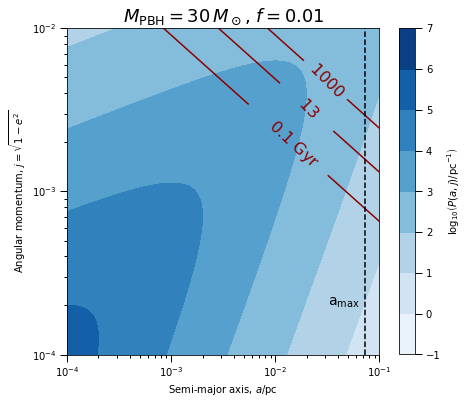

In [6]:

M_PBH_ref = 30.
f_ref  = 0.01

amin = 5.e-5
amax = a_max(f_ref, M_PBH_ref)

P1 = lambda y,x,f,M_PBH: P_a_j(x, y, f, M_PBH)
Norm1 =  dblquad(P1, amin, amax, lambda x: 0,  lambda x: 1, args=(f_ref, M_PBH_ref), epsrel=1e-20)[0]

a_list = np.logspace(-5, np.log10(amax*1.5), 501)
j_list = np.logspace(-5, -2, 501)

a_grid, j_grid = np.meshgrid(a_list, j_list, indexing='xy')
e_grid = np.sqrt(1-j_grid**2)

P_a_j_vec = np.vectorize(P_a_j, excluded=(2,3))

pl.figure(figsize=(7,6))

cf = pl.contourf(a_grid,j_grid, np.log10(P_a_j_vec(a_grid, j_grid, f_ref, M_PBH_ref)/Norm1), cmap="Blues")
pl.colorbar(cf,label=r"$\log_{10}\left(P(a, j)/\mathrm{pc}^{-1} \right)$")

CS = pl.contour(a_grid, j_grid, t_coal(a_grid, e_grid, M_PBH_ref)/(1e9), levels=[0.1,13.0,1000.0],colors='DarkRed' )

pl.clabel(CS, levels=[13.0],  # label every second level
           inline=1,
           fmt='    %1.f    ',
           fontsize=16,
            manual=([0.018, 0.003],))

pl.clabel(CS, levels=[1000.],  # label every second level
           inline=1,
           fmt='    %1.f    ',
           fontsize=16,
            manual=([0.045, 0.006],))

pl.clabel(CS, levels=[0.1],  # label every second level
           inline=1,
           #fmt='$t_\\mathrm{merge}$=%1.1f Gyr$\,$ ',
           fmt='    %1.1f Gyr$\,$    ',
           fontsize=16,
            manual=([0.005, 0.001],))

pl.xlabel("Semi-major axis, $a/\mathrm{pc}$")
pl.ylabel("Angular momentum, $j = \sqrt{1-e^2}$")
pl.title(r"$M_\mathrm{PBH} = " + str(int(M_PBH_ref)) + "\,M_\odot$, $f = " + str(f_ref) + "$",fontsize=18)

pl.axvline(a_max(0.01, 30.), linestyle='--', color='k')

pl.xlim(1.e-4, 0.1)
pl.ylim(1.e-4, 0.01)
pl.xscale("log")
pl.yscale("log")

pl.text(0.032, 0.0002,r"a$_{\rm max}$",color='black',fontsize=14.0)

pl.savefig("PDF.pdf",bbox_inches="tight")

pl.show()

## Setting up the 'remapping' prescription

Code for calculating $(a_i,j_i) \rightarrow (a_f, j_f)$.

In [7]:

def calcBindingEnergy(r_tr, M_PBH):
    
    integ = lambda r: Menc(r, r_tr, M_PBH)*rho(r, r_tr, M_PBH)*r
    return -G_N*4*np.pi*quad(integ, 1e-8, 1.0*r_tr, epsrel=1e-3)[0]

def getBindingEnergy(r_tr, f, M_PBH):
    
    global current_MPBH, Ubind_interp, rtr_interp
    
    if ((M_PBH - current_MPBH)**2 >1e-3 or Ubind_interp == None):
        
        print("I need to generate the r_tr(a) interpolation function for M = ", M_PBH)
        
        current_MPBH = M_PBH
        #print("   Tabulating binding energy and truncation radius (M_PBH = " + str(M_PBH) +")...")
        
        rtr_vals = np.logspace(np.log10(1e-8), np.log10(1.0*r_eq(M_PBH)), 500)
        Ubind_vals = np.asarray([calcBindingEnergy(r1, M_PBH) for r1 in rtr_vals])
        Ubind_interp = interp1d(rtr_vals, Ubind_vals)
        
        rtr_interp = GetRtrInterp(M_PBH)
        print("a = 0.001; r_tr = ", rtr_interp(0.001))
        print("a = 0.01; r_tr = ", rtr_interp(0.01))
                
    return Ubind_interp(r_tr) 


def calc_af(ai, f, M_PBH):
    
    global current_MPBH, rtr_interp, Ubind_interp
    
    if ((M_PBH - current_MPBH)**2 > 1e-3 or (rtr_interp == None)):
        
        print("I have to generate the r_tr(a) interpolation function! ")
        
        current_MPBH = M_PBH
       
        rtr_vals = np.logspace(np.log10(1.e-8), np.log10(1.0*r_eq(M_PBH)), 500)
        Ubind_vals = np.asarray([calcBindingEnergy(r1, M_PBH) for r1 in rtr_vals])
        Ubind_interp = interp1d(rtr_vals, Ubind_vals)
        
        rtr_interp = GetRtrInterp(M_PBH)

        print("0.001 -> ", rtr_interp(0.001))
        print("0.01 -> ",  rtr_interp(0.01))
    
    #r_tr = CalcTruncRadius(ai, M_PBH)
    if (rtr_interp == None):
        print("warning! no interpolation function")
 
    r_tr = rtr_interp(ai)

    Mtot = Menc(r_tr, r_tr, M_PBH)
    #print Mtot
    U_orb_before = -G_N*(Mtot**2)/(2.0*ai)
    
    if (r_tr > r_eq(M_PBH)):
        Ubind =  getBindingEnergy(r_eq(M_PBH), f, M_PBH)
    else:
        #print r_tr, r_eq(M_PBH)
        Ubind = getBindingEnergy(r_tr, f, M_PBH)
        
    return -G_N*M_PBH**2*0.5/(U_orb_before + 2.0*Ubind)


def calc_jf(ji, ai, f, M_PBH):
    
    af = calc_af(ai, f, M_PBH)
    return ji*np.sqrt(ai/af)


def calc_Tf(Ti, ai, f, M_PBH):
    
    af = calc_af(ai, f, M_PBH)
    return Ti*np.sqrt(af/ai)

## Monte Carlo sampling procedure

In [8]:
tmin_sampling = 1.e8
tmax_sampling = 1.e11

def lnprior(theta, M_PBH, a1, a2):    
    la, lj = theta
    a = 10**la
    j = 10**lj
    
    if (j > 1):
        return -np.inf
    
    if (a < a1 or a > a2):
        return -np.inf
        
    t = t_coal(a, np.sqrt(1.-j**2), M_PBH=M_PBH)
    if (t < tmin_sampling or t > tmax_sampling):
        return -np.inf
    
    return 0

#Log-probability
def lnprob(theta, f, M_PBH, PDF, a1, a2):
    lp = lnprior(theta, M_PBH, a1, a2)
    if not np.isfinite(lp):
        return -np.inf
    
    la, lj = theta
    
    #print la, lj, PDF(la, lj, f, M_PBH)
    
    return lp + np.log(PDF(la, lj, f, M_PBH))

#Sampler
#PDF should be a function of the form P_la_lj(la, lj, f, M_PBH)
#a1 and a2 are the desired ranges for a
def GetSamples_MCMC(N_samps, PDF, a1, a2, f, M_PBH):
    
    print("This is GetSamples_MCMC from a1 = ", a1, " to a2 = ", a2)
    
    ndim, nwalkers = 2, 100
    
    a0 = np.sqrt(a1*a2)
    j0 = j_coal(a0, 13e9, M_PBH)
    
    #print a0, j0

    p0 = [[np.log10(a0), np.log10(j0)] + 0.01*np.random.rand(ndim) for i in range(nwalkers)]
    #print p0
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[f, M_PBH,PDF, a1, a2])
    sampler.run_mcmc(p0, N_samps)
    
    samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))
    stride = 5
    print("   Generated ", len(samples[::stride,:]), "samples...")
    return samples[::stride,:]

## Compute the rate from sampled and remapped Ali-Haimoud distribution - Analytical

#### First define the integrals for P(t)

In [9]:
def P_t_integ(a, t, f, M_PBH, withHalo):
        
    c = 3.e5 #km/s
    Q = (c**6)*(3.0/170.0)*(G_N*M_PBH)**-3 # pc^-3
    t_pc = t*(60*60*24*365)*c*3.24078e-14 #Time in years -> Time in parsec    
    ecc = np.sqrt(1-(t_pc*1.0/(Q*a**4))**(2.0/7.0))
    j_ecc = np.sqrt(1. - ecc**2.)
    
    P1 = 1.
    if (withHalo == False):
        P1 = P_a_j(a, j_ecc, f, M_PBH)
    else:
        P1 = P_a_j_withHalo(a, j_ecc, f, M_PBH)
    
    djdt = j_ecc/(7*t)
    return P1*djdt

#Time in years
def P_t_of_z_analytical(z, f, M_PBH, withHalo):
    
    t = t_univ(z)
        
    avals = np.logspace(np.log10(amin), np.log10(amax), 101) #pc
    test = np.asarray([P_t_integ(a, t, f, M_PBH, withHalo) for a in avals])
    
    integr = np.trapz(test, avals, withHalo)

    return integr

def P_of_t_analytical(t, f, M_PBH, withHalo): 
        
    avals = np.logspace(np.log10(amin), np.log10(amax), 101) #pc
    test = np.asarray([P_t_integ(a, t, f, M_PBH, withHalo) for a in avals])
    
    integr = np.trapz(test, avals)

    return integr

###########################################################################

t_vec = np.logspace(np.log10(tmin_sampling), np.log10(tmax_sampling), 1000)
P_true = np.asarray([P_of_t_analytical(t_, f_ref, M_PBH_ref, withHalo=False) for t_ in t_vec])
P_true_withHalo = np.asarray([P_of_t_analytical(t_, f_ref, M_PBH_ref, withHalo=True) for t_ in t_vec])
int_analytical = np.trapz(P_true, t_vec)
int_analytical_withHalo = np.trapz(P_true_withHalo, t_vec)

# Example: 20 and 40 Msun
#integrand_20 = lambda x: n_PBH(f_ref, 30.)*sens_20Msun(x)*P_t_of_z_analytical(x, f_ref, 30., withHalo=False) # Gpc^(-3) * Gpc^3 yr * yr^(-1)
#integrand_40 = lambda x: n_PBH(f_ref, 30.)*sens_40Msun(x)*P_t_of_z_analytical(x, f_ref, 30., withHalo=False)
#N_20 = quad(integrand_20, 0, 0.7)[0]
#N_40 = quad(integrand_40, 0, 0.7)[0]
#N_20_flat = quad(sens_20Msun, 0, 0.7)[0]
#N_40_flat = quad(sens_40Msun, 0, 0.7)[0]
#print("Analytical Merger Rate [Gpc^-3 yr^-1] for 20 and 40 Msun:", N_20/N_20_flat," - ",N_40/N_40_flat)

#### Calculate 'remapped' rate using MC sampling

Note that this may take a while (where a while is probably a few hours). You may want to read in the files `data/rate_averaged_100.0.txt` (etc) instead.

65536
 
*** M =  10.0
rtr_interp == none
current_MPBH =  -10.0
 
*** f =  0.0001
rtr_interp == none
current_MPBH =  -10.0
Sampling PDF... 
This is GetSamples_MCMC from a1 =  5e-05  to a2 =  0.0634782391776
   Generated  1290720 samples...
...done!
max a from GetSamples =  0.063476744307
I have to generate the r_tr(a) interpolation function! 
0.001 ->  0.0007150146077005914
0.01 ->  0.0038916203259163314
fraction of binaries that merge today =  1.4124475079344178e-11 ; averaged =   2.302324221921128e-11
0.0001	0.145031789422	0.281580371742

*** f =  0.000143844988829
current_MPBH =  10.0
Sampling PDF... 
This is GetSamples_MCMC from a1 =  5e-05  to a2 =  0.0634782391776
   Generated  1290720 samples...
...done!
max a from GetSamples =  0.0634757307224
fraction of binaries that merge today =  1.4193883626619235e-11 ; averaged =   2.2643085573171544e-11
0.000143844988829	0.300052642591	0.572932219628

*** f =  0.000206913808111
current_MPBH =  10.0
Sampling PDF... 
This is GetSamples_MCMC

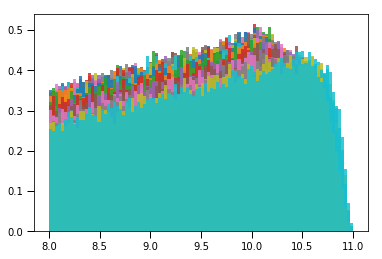

In [10]:
Nm = 3
Nf = 20
zmax = 1.0
Nsamples = 2**16
print(Nsamples)
rtr_interp = None

f_vec = np.logspace(-4.,-1., Nf)
m_vec = np.array([10., 30., 100.])
rate_vec = np.zeros((Nm,Nf))
rate_remapped_vec = np.zeros((Nm,Nf))

for i_m in range(Nm):
    
    print(" ")
    print("*** M = ", m_vec[i_m])   
    
    if (rtr_interp == None):
        print("rtr_interp == none")
    print("current_MPBH = ", current_MPBH)
    print(" ")    
        
    current_file = "rate_averaged_" + str(m_vec[i_m]) + ".txt"
    out_f = open(current_file, 'w')
    
    for i_f in range(Nf):    
            
        print("*** f = ", f_vec[i_f])
        
        if (rtr_interp == None):
            print("rtr_interp == none")
        print("current_MPBH = ", current_MPBH)

        print("Sampling PDF... ")
        #print("amax = ", a_max(f_vec[i_f], m_vec[i_m]))
        samples_MCMC = GetSamples_MCMC(Nsamples, P_la_lj_withHalo, amin, a_max_with_Halo(f_vec[i_f], m_vec[i_m]), f_vec[i_f], m_vec[i_m])
        print("...done!")

        la_vals_all = samples_MCMC[:,0]
        print("max a from GetSamples = ", 10.**(np.amax(la_vals_all)))
        lj_vals_all = samples_MCMC[:,1]
        z_vals_all = np.zeros(Nsamples)
        t_vals_all = np.zeros(Nsamples)

        z_vals_remapped = np.zeros(Nsamples)
        t_vals_remapped = np.zeros(Nsamples)

        for ind in range(Nsamples):  
            
            a_ = 10.**(la_vals_all[ind])
            j_ = 10.**(lj_vals_all[ind])
            e_ = np.sqrt(1. -  (j_**2.))
            
            current_t_coal = t_coal(a_, e_, m_vec[i_m])             
            t_vals_all[ind] = current_t_coal        
            
            remapped_a = calc_af(a_, f_vec[i_f], m_vec[i_m])
            remapped_j = calc_jf(j_, a_, f_vec[i_f], m_vec[i_m])
            remapped_e = np.sqrt(1. -  (remapped_j**2.))
            
            remapped_t_coal = t_coal(remapped_a, remapped_e, m_vec[i_m]) 
            t_vals_remapped[ind] = remapped_t_coal
            
        bins_t = np.logspace(np.log10(tmin_sampling), np.log10(tmax_sampling), 101)
        logBins_t = np.linspace(np.log10(tmin_sampling), np.log10(tmax_sampling), 101)
        bins_t_centres = np.sqrt(bins_t[:-1]*bins_t[1:])
        
        nt_remapped, bins_t_remapped, patches = pl.hist(np.log10(t_vals_remapped), bins=logBins_t, normed=True, alpha=0.85)
        nt_remapped_normalized = nt_remapped/(bins_t_centres*np.log(10))        
        
        P_t_remapped_numerical = interp1d(bins_t_centres, nt_remapped_normalized, kind='linear')
        
        t_vec = np.logspace(np.log10(tmin_sampling), np.log10(tmax_sampling), 1000)
        P_true_withHalo = np.asarray([P_of_t_analytical(t_, f_vec[i_f], m_vec[i_m], withHalo=True) for t_ in t_vec])
        int_analytical_withHalo = np.trapz(P_true_withHalo, t_vec)

        my_integrand = lambda x: P_t_remapped_numerical(t_univ(x)) 
        my_integral = quad(my_integrand, 0.0, zmax)[0] / zmax

        rate_vec[i_m, i_f] = n_PBH(f_vec[i_f], m_vec[i_m]) * P_t_of_z_analytical(0., f_vec[i_f], m_vec[i_m], withHalo=False)                
        rate_remapped_vec[i_m, i_f] = n_PBH(f_vec[i_f],m_vec[i_m]) * my_integral * int_analytical_withHalo #_withHalo

        print("fraction of binaries that merge today = ", P_t_remapped_numerical(t_univ(0.)), "; averaged =  ",  my_integral)
        
        current_str = str(f_vec[i_f]) + "\t" + str(rate_vec[i_m, i_f]) + "\t" + str(rate_remapped_vec[i_m, i_f])+"\n"
        print(current_str)
        out_f.write(current_str)
        
    out_f.close()

#### Calculate 'analytic' rate without DM mini-halos

In [11]:
Nm = 3
Nf_analytical = 100
f_vec_analytical = np.logspace(-5.,0., Nf_analytical)
m_vec = np.array([10., 30., 100.])
rate_vec_analytical = np.zeros((Nm,Nf_analytical))
print(f_vec_analytical)

for i_m in range(Nm):
    
    print("*** M = ", m_vec[i_m])
        
    for i_f in range(Nf_analytical):    
        
        my_integrand_an = lambda x: P_t_of_z_analytical(x, f_vec_analytical[i_f], m_vec[i_m], withHalo=False)
        my_integral_an = quad(my_integrand_an, 0.0, zmax)[0] / zmax 
    
        rate_vec_analytical[i_m, i_f] = n_PBH(f_vec_analytical[i_f], m_vec[i_m]) * my_integral_an # P_t_of_z_analytical(0., f_vec_analytical[i_f], m_vec[i_m], withHalo=False)

[  1.00000000e-05   1.12332403e-05   1.26185688e-05   1.41747416e-05
   1.59228279e-05   1.78864953e-05   2.00923300e-05   2.25701972e-05
   2.53536449e-05   2.84803587e-05   3.19926714e-05   3.59381366e-05
   4.03701726e-05   4.53487851e-05   5.09413801e-05   5.72236766e-05
   6.42807312e-05   7.22080902e-05   8.11130831e-05   9.11162756e-05
   1.02353102e-04   1.14975700e-04   1.29154967e-04   1.45082878e-04
   1.62975083e-04   1.83073828e-04   2.05651231e-04   2.31012970e-04
   2.59502421e-04   2.91505306e-04   3.27454916e-04   3.67837977e-04
   4.13201240e-04   4.64158883e-04   5.21400829e-04   5.85702082e-04
   6.57933225e-04   7.39072203e-04   8.30217568e-04   9.32603347e-04
   1.04761575e-03   1.17681195e-03   1.32194115e-03   1.48496826e-03
   1.66810054e-03   1.87381742e-03   2.10490414e-03   2.36448941e-03
   2.65608778e-03   2.98364724e-03   3.35160265e-03   3.76493581e-03
   4.22924287e-03   4.75081016e-03   5.33669923e-03   5.99484250e-03
   6.73415066e-03   7.56463328e-03

## Plot Merger Rates

[[  1.45031789e-01   3.00052643e-01   6.20705246e-01   1.28375836e+00
    2.65401422e+00   5.48237364e+00   1.13064251e+01   2.32420184e+01
    4.74767165e+01   9.58482305e+01   1.89655579e+02   3.64264448e+02
    6.74841036e+02   1.20781447e+03   2.10545136e+03   3.60844511e+03
    6.12386683e+03   1.03361487e+04   1.73918009e+04   2.92069685e+04]
 [  5.28257678e-02   1.09291095e-01   2.26090934e-01   4.67631214e-01
    9.66876897e-01   1.99772907e+00   4.12192355e+00   8.48139149e+00
    1.73577746e+01   3.51649755e+01   6.99854763e+01   1.35526598e+02
    2.53461045e+02   4.57613386e+02   8.03055223e+02   1.38247916e+03
    2.35254284e+03   3.97667664e+03   6.69615527e+03   1.12485097e+04]
 [  1.52712245e-02   3.15959569e-02   6.53684579e-02   1.35228241e-01
    2.79702939e-01   5.78354857e-01   1.19518163e+00   2.46694558e+00
    5.07972332e+00   1.04079680e+01   2.11109807e+01   4.20145660e+01
    8.11377090e+01   1.50983553e+02   2.71264637e+02   4.74525616e+02
    8.15600408e+02

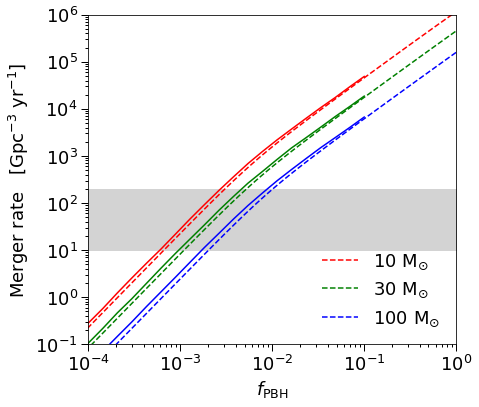

In [13]:
from scipy.interpolate import UnivariateSpline

print(rate_vec)
print(rate_remapped_vec)

mpl.rc('font', **{'size'   : 18})


pl.figure(figsize=(7,6))

col = np.array(["red","green","blue"])

for iM in range(Nm):
    
    current_file = "rate_averaged_" 
    if (iM==0):
        lab="10 M$_{\odot}$"
        current_file += (str(m_vec[iM]) + ".txt")
    if (iM==1):
        lab="30 M$_{\odot}$"
        current_file += (str(m_vec[iM]) + ".txt")
    if (iM==2):
        lab="100 M$_{\odot}$"
        current_file += (str(m_vec[iM]) + ".txt")
        
    print("Reading ",current_file)        
    
    f_vec, rate_remapped_vec = np.loadtxt(current_file, usecols=(0, 2), unpack=True)  
        
    pl.loglog(f_vec_analytical, rate_vec_analytical[iM,:], linewidth=1.5, ls="--", label=lab, color=col[iM])
    pl.loglog(f_vec, rate_remapped_vec, linewidth=1.5, ls="-", color=col[iM])
    
pl.xlim(1.e-4,1.)
pl.ylim(.1,1.e6)

pl.fill_between(f_vec_analytical, 10., 200.0, color="lightGrey")
    
pl.xlabel(r"$f_{\rm PBH}$")
pl.ylabel(r"Merger rate   [Gpc$^{-3}$ yr$^{-1}$]")
pl.tight_layout()

pl.legend(loc='lower right', frameon=False)
pl.savefig("../plots/mergerRate_remapped.pdf", format='pdf')

pl.show()